In [39]:
import pandas as pd
from supersmoother import SuperSmoother
import pickle
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import numpy as np
from PS5 import load_channel_data, normal_binify, my_peaks, linear_guass
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.interpolate import RegularGridInterpolator

sns.set(style="whitegrid", context="talk")

In [2]:
channel_data = load_channel_data()
values1 = channel_data.loc[1, "values"]
times1 = channel_data.loc[1, "time"]
times1 -= times1.min()
trim_value = 130000

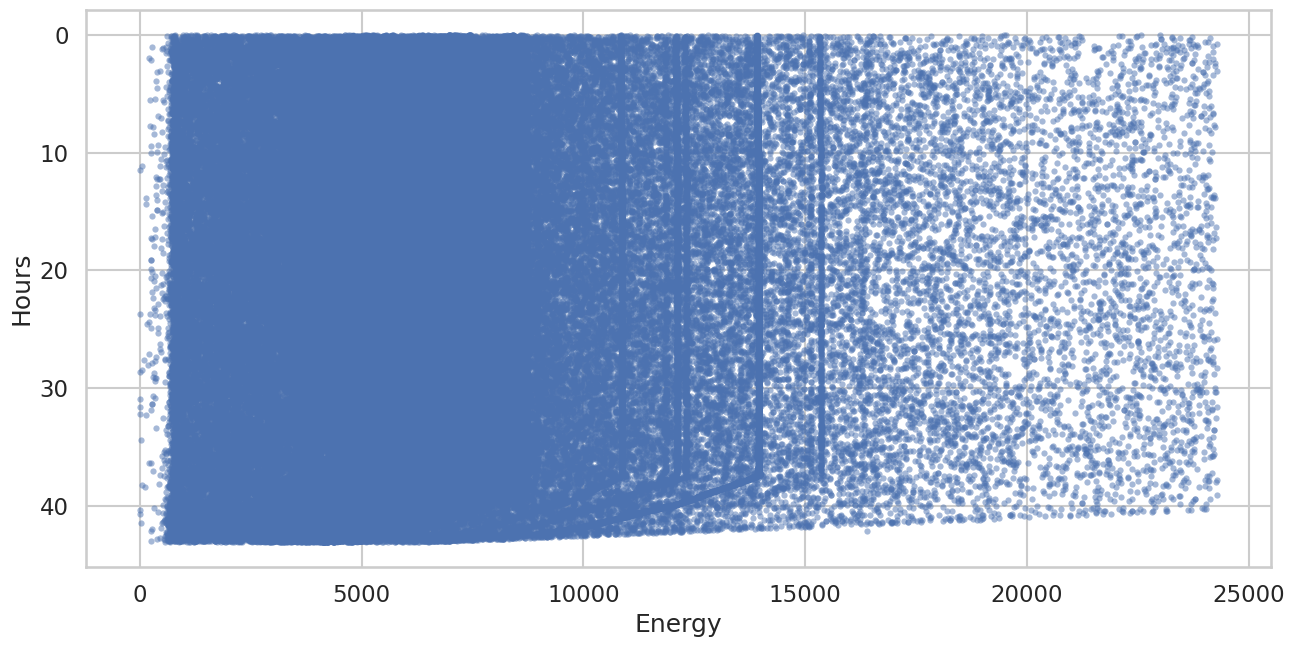

In [ ]:
ax1 = sns.scatterplot(x=values1, y=times1 / 60 / 60, marker=".", linewidth=0, alpha=0.5)
ax1.set_xlabel("Energy")
ax1.set_ylabel("Hours")
ax1.invert_yaxis()
ax1.figure.set_size_inches(13.32, 6.81)
ax1.figure.tight_layout()

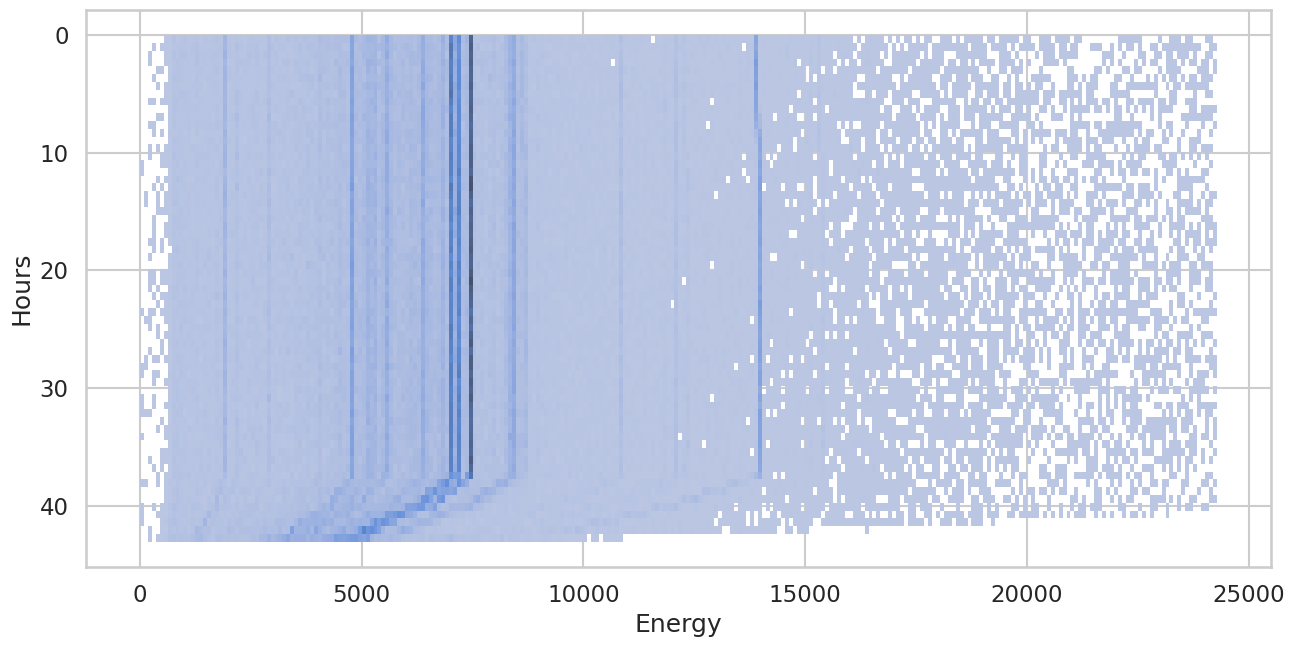

In [ ]:
ax1 = sns.histplot(x=values1, y=times1 / 60 / 60)
ax1.set_xlabel("Energy")
ax1.set_ylabel("Hours")
ax1.invert_yaxis()
ax1.figure.set_size_inches(13.32, 6.81)
ax1.figure.tight_layout()

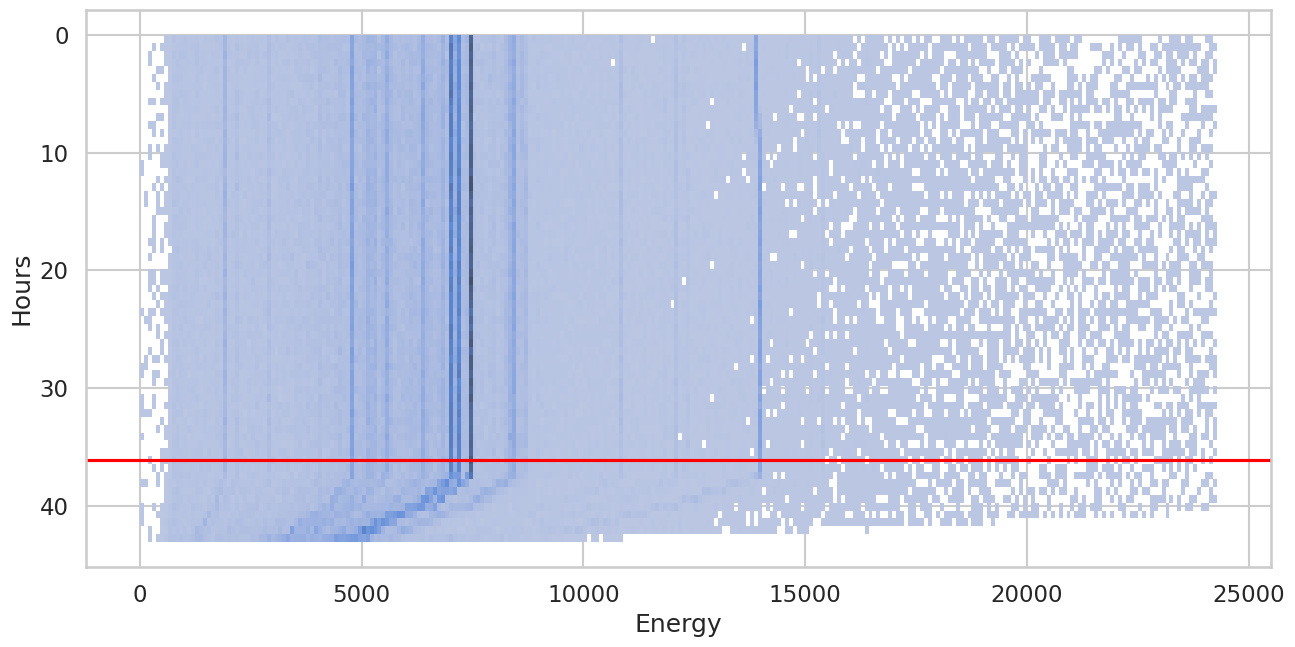

In [ ]:
ax1 = sns.histplot(x=values1, y=times1 / 60 / 60)
ax1.set_xlabel("Energy")
ax1.set_ylabel("Hours")
ax1.invert_yaxis()
ax1.axhline(trim_value / 60 / 60, color="red")
ax1.figure.set_size_inches(13.32, 6.81)
ax1.figure.tight_layout()

before_falloff_mask = times1 < trim_value
times1 = times1[before_falloff_mask]
values1 = values1[before_falloff_mask]

In [6]:
with open("peaks1.pickle", "rb") as f:
    peaks1, hist, bins = pickle.load(f)

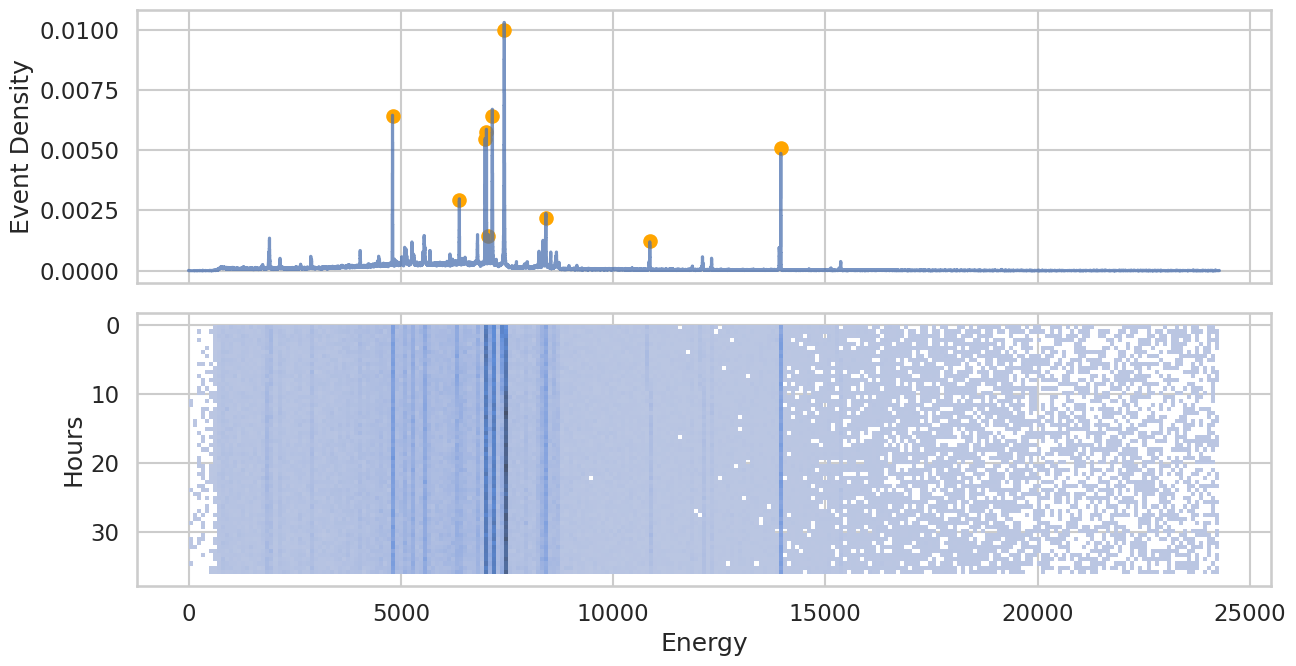

In [7]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.histplot(x=values1, y=times1 / 60 / 60, ax=ax1)
ax1.set_xlabel("Energy")
ax1.set_ylabel("Hours")
ax1.invert_yaxis()

ax0.step(bins, hist, where="mid", alpha=0.75)
most_prominent = peaks1[-10:].sort_values("center").reset_index(drop=True)
ax0.scatter(
    most_prominent["center"], most_prominent.eval("height + offset"), color="orange"
)
ax0.set_ylabel("Event Density")

fig.set_size_inches(13.32, 7)
fig.tight_layout()

In [8]:
def plotpeak(peak, ax=None, basecolor="grey", peakcolor="orange", bound=2, num=50):
    [center, height, std, offset, slope] = peak

    try:
        left, right = bound
    except TypeError:
        left = center - bound * std
        right = center + bound * std

    ax = ax or plt.gca()

    xs = np.linspace(left, right, num=50)
    baseline = (xs - center) * slope + offset
    curve = linear_guass(xs, *peak)
    ax.plot(xs, baseline, color=basecolor)
    ax.plot(xs, curve, color=peakcolor)

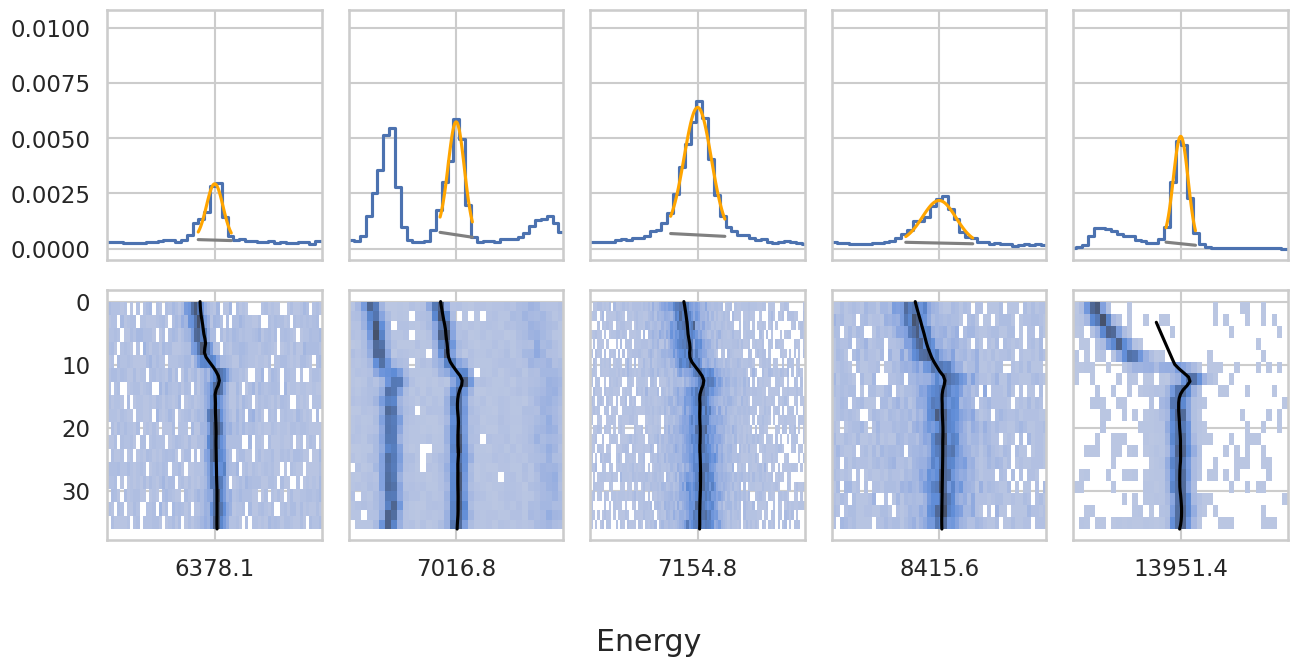

In [129]:
fig, axes = plt.subplots(
    nrows=2, ncols=len(most_prominent[1::2]), sharex="col", sharey="row"
)

for (ax0, ax1), (colid, peak) in zip(axes.T, most_prominent[1::2].iterrows()):
    window_left = peak["center"] - 50
    window_right = peak["center"] + 50
    peak_display_window = (values1 > window_left) & (values1 < window_right)

    ax0.step(bins, hist, where="mid")
    plotpeak(peak, ax=ax0)
    if colid == 0:
        ax0.set_ylabel("Event Density")

    sns.histplot(
        x=values1[peak_display_window], y=times1[peak_display_window] / 60 / 60, ax=ax1
    )
    ax1.invert_yaxis()
    if colid == 0:
        ax1.set_ylabel("Hours")
    ax1.set_xlim(window_left, window_right)
    ax1.set_xticks([peak["center"]])

    smooth_width = 3
    peak_left = peak["center"] - smooth_width * peak["std"]
    peak_right = peak["center"] + smooth_width * peak["std"]
    in_peak_mask = (peak_left < values1) & (values1 < peak_right)
    peak_times = times1[in_peak_mask]
    peak_values = values1[in_peak_mask]

    model = SuperSmoother()
    model.fit(peak_times, peak_values)
    ts = np.linspace(peak_times.min(), peak_times.max())
    smooth_energies = model.predict(ts)
    ax1.plot(smooth_energies, ts / 60 / 60, color="black")

fig.supxlabel("Energy")
fig.set_size_inches(13.32, 6.81)
fig.tight_layout()

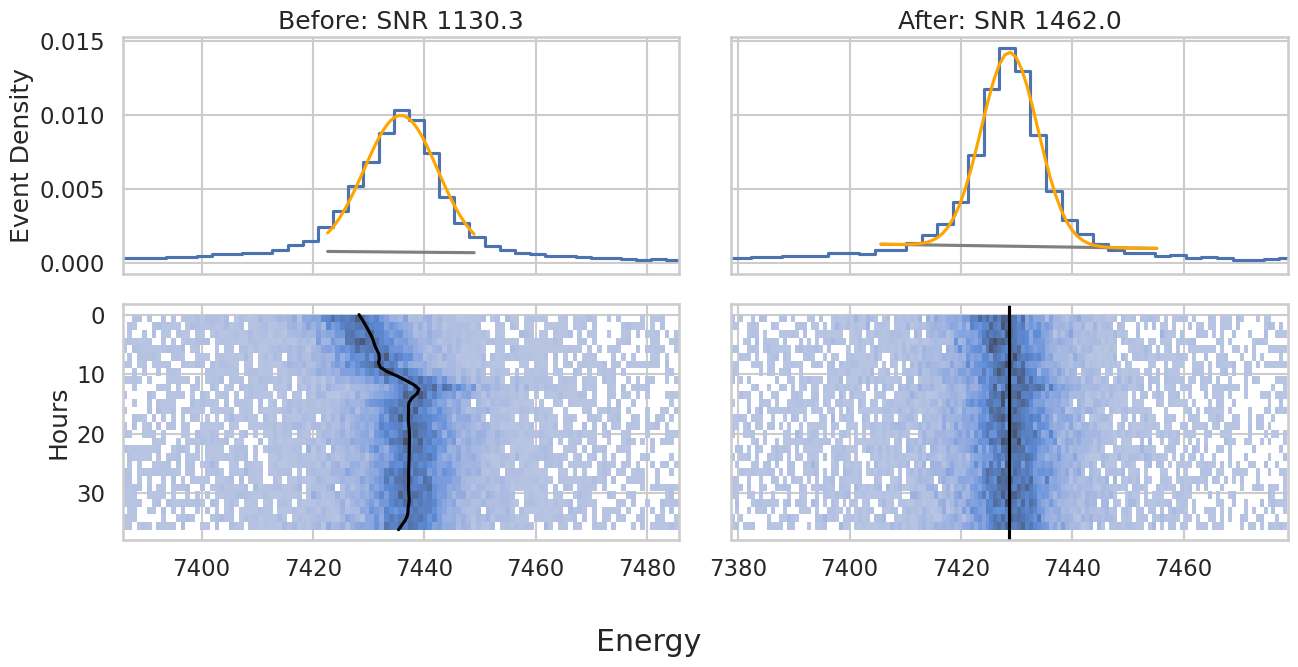

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row")

peak = most_prominent.loc[6]

smooth_width = 3
peak_left = peak["center"] - smooth_width * peak["std"]
peak_right = peak["center"] + smooth_width * peak["std"]
in_peak_mask = (peak_left < values1) & (values1 < peak_right)
peak_times = times1[in_peak_mask]
peak_values = values1[in_peak_mask]

model = SuperSmoother()
model.fit(peak_times, peak_values)
ts = np.linspace(peak_times.min(), peak_times.max())
smooth_energies = model.predict(ts)

num_start = int(len(peak_values) * 0.03)
start_energy = peak_values[:num_start].mean()

window_left_pre = peak["center"] - 50
window_right_pre = peak["center"] + 50
peak_pre_display_window = (values1 > window_left_pre) & (values1 < window_right_pre)

sns.histplot(
    x=values1[peak_pre_display_window],
    y=times1[peak_pre_display_window] / 60 / 60,
    ax=axes[1, 0],
)

axes[0, 0].step(bins, hist, where="mid")
plotpeak(peak, ax=axes[0, 0])

axes[1, 0].plot(smooth_energies, ts / 60 / 60, color="black")

drift = model.predict(times1) - start_energy
adjusted_values = values1 - drift
ahist, abins = normal_binify(adjusted_values)
fit_left = peak_left - drift.max()
fit_right = peak_right + drift.min()
in_adjusted_peak_mask = (fit_left < abins) & (abins < fit_right)
newpeak, _ = curve_fit(
    linear_guass,
    abins[in_adjusted_peak_mask],
    ahist[in_adjusted_peak_mask],
    p0=peak.values,
    bounds=(
        [fit_left, 0, 0, 0, -np.inf],
        [fit_right, ahist.max(), np.inf, ahist.max(), np.inf],
    ),
)
newpeak = pd.Series(newpeak, index=["center", "height", "std", "offset", "slope"])
window_left_post = newpeak["center"] - 50
window_right_post = newpeak["center"] + 50
peak_post_display_window = (window_left_post < adjusted_values) & (
    adjusted_values < window_right_post
)
axes[0, 1].step(abins, ahist, where="mid")
plotpeak(newpeak, ax=axes[0, 1], bound=(fit_left, fit_right))
sns.histplot(
    x=adjusted_values[peak_post_display_window],
    y=times1[peak_post_display_window] / 60 / 60,
    ax=axes[1, 1],
)
axes[1, 1].axvline(start_energy, color="black")

axes[1, 0].invert_yaxis()
axes[0, 0].set_xlim(window_left_pre, window_right_pre)
axes[0, 1].set_xlim(window_left_post, window_right_post)
axes[0, 0].set_ylabel("Event Density")
axes[1, 0].set_ylabel("Hours")

axes[0, 0].set_title(f"Before: SNR {peak['center'] / peak['std']:.1f}")
axes[0, 1].set_title(f"After: SNR {newpeak['center'] / newpeak['std']:.1f}")
fig.supxlabel("Energy")
fig.set_size_inches(13.32, 6.81)
fig.tight_layout()

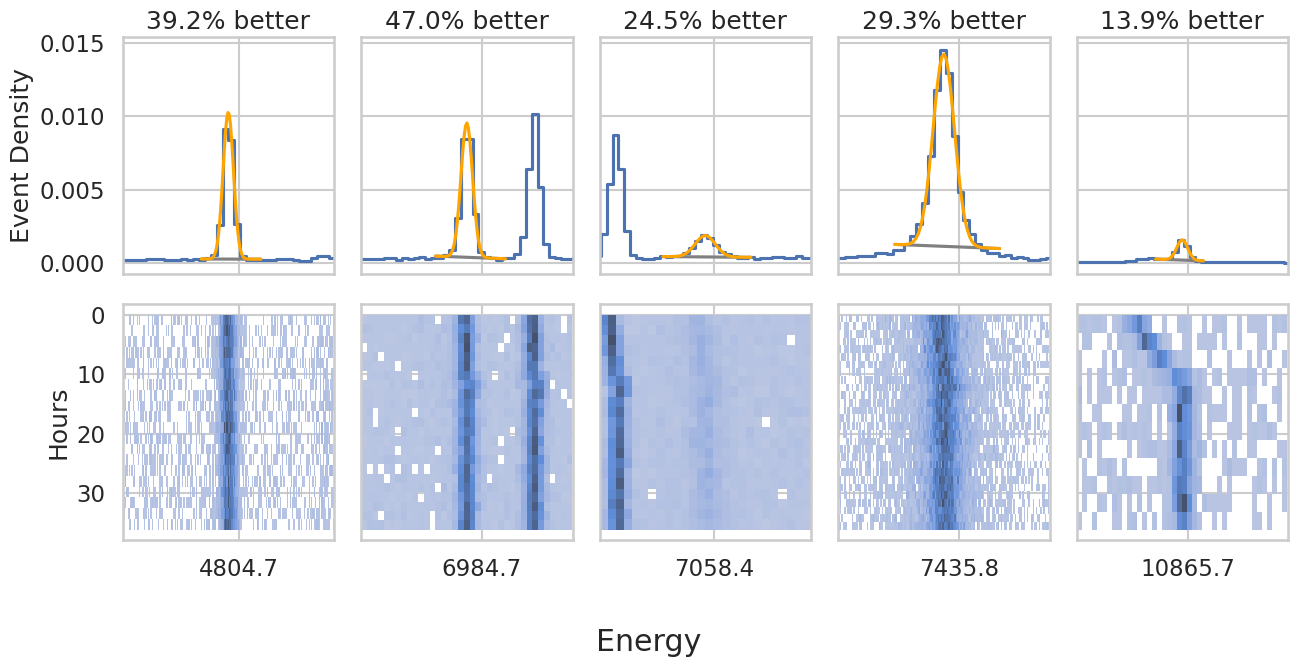

In [132]:
fig, axes = plt.subplots(
    nrows=2, ncols=len(most_prominent[::2]), sharex="col", sharey="row"
)

interp_dict = {}
ts = np.linspace(times1.min(), times1.max(), 100)

for (ax0, ax1), (colid, peak) in zip(axes.T, most_prominent[::2].iterrows()):
    smooth_width = 3
    peak_left = peak["center"] - smooth_width * peak["std"]
    peak_right = peak["center"] + smooth_width * peak["std"]
    in_peak_mask = (peak_left < values1) & (values1 < peak_right)
    peak_times = times1[in_peak_mask]
    peak_values = values1[in_peak_mask]

    model = SuperSmoother()
    model.fit(peak_times, peak_values)

    num_start = int(len(peak_values) * 0.03)
    start_energy = peak_values[:num_start].mean()

    interp_dict[peak["center"]] = model.predict(ts) - start_energy

    drift = model.predict(times1) - start_energy
    adjusted_values = values1 - drift
    ahist, abins = normal_binify(adjusted_values)
    fit_left = peak_left - drift.max()
    fit_right = peak_right + drift.min()
    in_adjusted_peak_mask = (fit_left < abins) & (abins < fit_right)
    newpeak, _ = curve_fit(
        linear_guass,
        abins[in_adjusted_peak_mask],
        ahist[in_adjusted_peak_mask],
        p0=peak.values,
        bounds=(
            [fit_left, 0, 0, 0, -np.inf],
            [fit_right, ahist.max(), np.inf, ahist.max(), np.inf],
        ),
    )
    newpeak = pd.Series(newpeak, index=["center", "height", "std", "offset", "slope"])
    window_left_post = newpeak["center"] - 50
    window_right_post = newpeak["center"] + 50
    peak_post_display_window = (window_left_post < adjusted_values) & (
        adjusted_values < window_right_post
    )
    ax0.step(abins, ahist, where="mid")
    plotpeak(newpeak, ax=ax0, bound=(fit_left, fit_right))
    sns.histplot(
        x=adjusted_values[peak_post_display_window],
        y=times1[peak_post_display_window] / 60 / 60,
        ax=ax1,
    )

    ax1.invert_yaxis()
    ax0.set_xlim(window_left_post, window_right_post)
    ax0.set_xticks([peak["center"]])
    if colid == 0:
        ax1.set_ylabel("Hours")
        ax0.set_ylabel("Event Density")

    old_snr = peak["center"] / peak["std"]
    new_snr = newpeak["center"] / newpeak["std"]
    ax0.set_title(f"{new_snr / old_snr * 100 - 100:.1f}% better")

fig.supxlabel("Energy")
fig.set_size_inches(13.32, 6.81)
fig.tight_layout()

In [133]:
es = np.array(list(interp_dict.keys()))
drift_grid = np.array(list(interp_dict.values()))
interp = RegularGridInterpolator(
    (es, ts), drift_grid, bounds_error=False, fill_value=None
)

count = 100
eshow = np.linspace(values1.min(), values1.max(), count)
tshow = np.linspace(times1.min(), times1.max(), count)
eshow, tshow = np.meshgrid(eshow, tshow)
interp_drifts = interp(np.vstack([eshow.flatten(), tshow.flatten()]).T).reshape(
    (count, count)
)

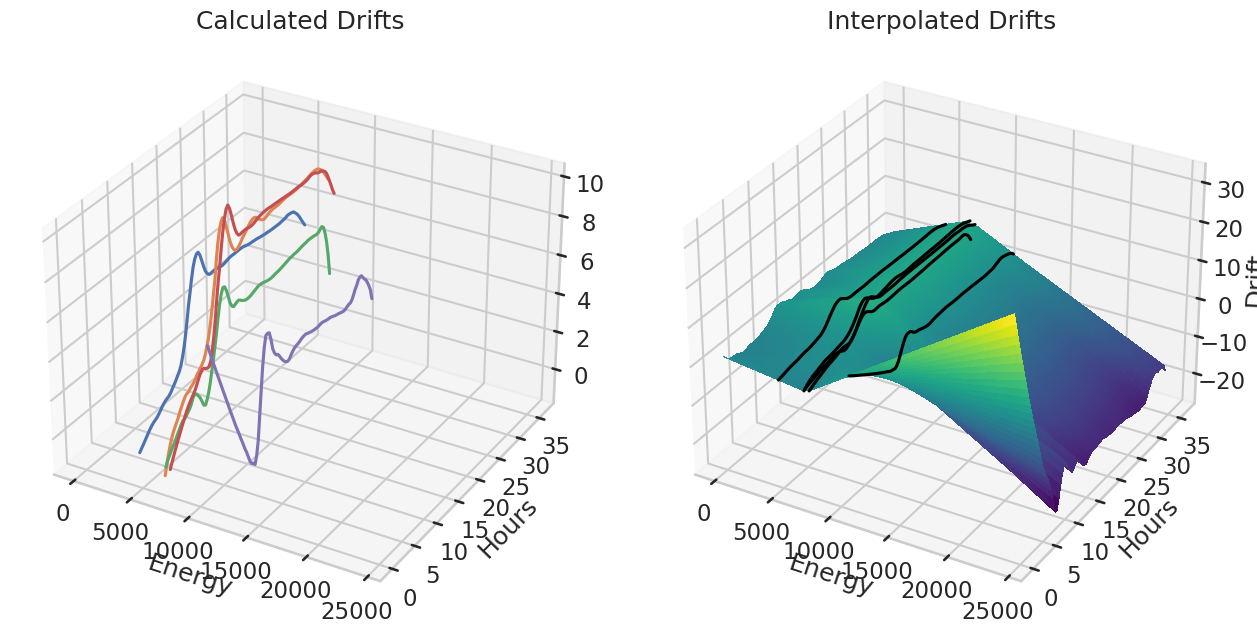

In [134]:
import operator
from matplotlib import animation

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d", sharex=ax1)


def init():
    for center, drifts in sorted(interp_dict.items(), key=operator.itemgetter(0)):
        ax1.plot(ts / 60 / 60, drifts, zs=center, zdir="x")
    ax1.set_title("Calculated Drifts")
    ax1.set_ylabel("Hours")
    ax1.set_xlabel("Energy")
    ax2.set_zlabel("Drift")
    ax2.set_ylabel("Hours")
    ax2.set_xlabel("Energy")
    ax2.plot_surface(
        eshow,
        tshow / 60 / 60,
        interp_drifts,
        ccount=count,
        rcount=count,
        cmap="viridis",
        linewidth=0,
        antialiased=False,
    )
    for center, drifts in sorted(interp_dict.items(), key=operator.itemgetter(0)):
        ax2.plot(ts / 60 / 60, drifts, zs=center, zdir="x", color="black")
    ax2.set_title("Interpolated Drifts")

    return (fig,)


def animate(i):
    ax1.view_init(elev=10, azim=i)
    ax2.view_init(elev=10, azim=i)
    return (fig,)


init()
fig.set_size_inches(13.32, 6.81)
fig.tight_layout(pad=2)
fig.savefig("/home/finally/Desktop/tmp.png")

In [ ]:
fig, axes = plt.subplots(
    nrows=2, ncols=len(most_prominent[1::2]), sharex="col", sharey="row"
)

all_drift = interp(np.vstack([values1, times1]).T)
adjusted_values = values1 - all_drift
ahist, abins = normal_binify(adjusted_values)

for (ax0, ax1), (colid, peak) in zip(axes.T, most_prominent[1::2].iterrows()):
    smooth_width = 3
    peak_left = peak["center"] - smooth_width * peak["std"]
    peak_right = peak["center"] + smooth_width * peak["std"]
    in_peak_mask = (peak_left < values1) & (values1 < peak_right)
    drift = all_drift[in_peak_mask]
    fit_left = peak_left - drift.max()
    fit_right = peak_right + drift.min()
    in_adjusted_peak_mask = (fit_left < abins) & (abins < fit_right)
    newpeak, _ = curve_fit(
        linear_guass,
        abins[in_adjusted_peak_mask],
        ahist[in_adjusted_peak_mask],
        p0=peak.values,
        bounds=(
            [fit_left, 0, 0, 0, -np.inf],
            [fit_right, ahist.max(), np.inf, ahist.max(), np.inf],
        ),
    )
    newpeak = pd.Series(newpeak, index=["center", "height", "std", "offset", "slope"])
    window_left_post = newpeak["center"] - 50
    window_right_post = newpeak["center"] + 50
    peak_post_display_window = (window_left_post < adjusted_values) & (
        adjusted_values < window_right_post
    )
    ax0.step(abins, ahist, where="mid")
    plotpeak(newpeak, ax=ax0, bound=(fit_left, fit_right))
    sns.histplot(
        x=adjusted_values[peak_post_display_window],
        y=times1[peak_post_display_window] / 60 / 60,
        ax=ax1,
    )

    ax1.invert_yaxis()
    ax0.set_xlim(window_left_post, window_right_post)
    ax0.set_xticks([peak["center"]])
    if colid == 0:
        ax1.set_ylabel("Hours")
        ax0.set_ylabel("Event Density")

    old_snr = peak["center"] / peak["std"]
    new_snr = newpeak["center"] / newpeak["std"]
    ax0.set_title(f"{new_snr / old_snr * 100 - 100:.1f}% better")

fig.supxlabel("Energy")
fig.set_size_inches(13.32, 6.81)
fig.tight_layout()